# Preprocessing

**Steps:**
1. The Denmark LPIS vector geometries are cleaned and simplified, the labels are reclassified to 5 crop classes.
2. The Sentinel-2 RGB-imagery is cut to 128x128-pixel image chips.
3. The prepared LPIS data is clipped to the chip geometries and saved in COCO annotation format.

Due to file size limitations, this repository only contains vector and satellite image data for a small subset of the full area of interest. The preprocessing of this demonstration data (area around Frederiksen, Denmark) results in 9 image chips. To work on the full dataset as presented in the thesis, you can download:
- [2016 LPIS dataset](https://kortdata.fvm.dk/download/Markblokke_Marker?page=MarkerHistoriske) ("Marker_2016_CVR.zip") via the Danish Ministery of Environment
- [Sentinel-2 mosaic](https://code.earthengine.google.com/c9ac3a79660b65525cfa59f1087cea9b) (2016/05/08, tiles 32VNH&T32UNG) via this Google Earth Engine script.

![](figures/preprocessing_demo.jpg)

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rasterio
import shapely
from pprint import pprint

import utils
from utils.other import new_pickle, load_pickle, new_json, load_json

## Vector preparation 

In [2]:
inpath_s2 = Path(r'data\RGB_small.tif')
inpath_fields = Path(r'data\marker2016_small.shp')

outpath = Path(r'output\preprocessed')

In [3]:
def prepare_vector(fp, out_crs, clipping_bounds):
    df = (gpd.read_file(str(fp), encoding='cp865')  # danish encoding
             .rename(columns={'Afgroede': 'lc_name', 'AfgKode': 'lc_id', 'JOURNALNUM': 'journalnr'})
             .drop(['GB', 'GEOMETRISK', 'MARKNUMMER'], axis=1)
             .pipe(utils.geo.explode_mp)
             .pipe(utils.geo.buffer_zero)
             .pipe(utils.geo.close_holes)
             .pipe(utils.geo.set_crs, 3044)
             .to_crs(out_crs)
             .pipe(utils.geo.clip, clip_poly=shapely.geometry.box(*clipping_bounds), explode_mp_=True)
             .pipe(utils.geo.reclassify_col, rcl_scheme=utils.geo.reclass_legend, 
                   col_classlabels='lc_name', col_classids='lc_id', drop_other_classes=True)
             .assign(geometry=lambda _df: _df.geometry.simplify(5, preserve_topology=True))
             .pipe(utils.geo.buffer_zero)
             .assign(area_sqm=lambda _df: _df.geometry.area)
             .pipe(utils.geo.reduce_precision, precision=4)
             .reset_index(drop=True)
             .assign(fid=lambda _df: range(0, len(_df.index)))
             .filter(['journalnr', 'lc_id', 'lc_name', 'r_lc_id', 'r_lc_name', 'area_sqm', 'fid', 'geometry']))
    return df

outpath_fields = outpath / 'prepared_vector.shp'

if not outpath_fields.exists():
    with rasterio.open(inpath_s2) as src:
        raster_meta = src.meta
        raster_bounds = src.bounds
    df = prepare_vector(inpath_fields, raster_meta['crs'], raster_bounds)
    outpath_fields.parent.mkdir(parents=True, exist_ok=True)
    df.to_file(outpath_fields, driver='ESRI Shapefile', encoding='cp865')
else:
    print(f'Loading from exisiting shp file... {outpath_fields.name}')
    df = gpd.read_file(str(outpath_fields), encoding='cp865')
     
print(df.info())
display(df.head(3))

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 8 columns):
journalnr    234 non-null object
lc_id        234 non-null object
lc_name      234 non-null object
r_lc_id      234 non-null int64
r_lc_name    234 non-null object
area_sqm     234 non-null float64
fid          234 non-null int32
geometry     234 non-null object
dtypes: float64(1), int32(1), int64(1), object(5)
memory usage: 13.8+ KB
None


,journalnr,lc_id,lc_name,r_lc_id,r_lc_name,area_sqm,fid,geometry
0,16-0020644,1,Vσrbyg,1,springcereal,6818.565562,0,"POLYGON ((516576.3102 6243070.0001, 516595.983..."
1,16-0036135,11,Vinterhvede,2,wintercereal,15477.545517,1,"POLYGON ((514093.8795 6243688.6454, 514192.095..."
2,16-0014547,280,Fodersukkerroer,5,other,54178.844742,2,"POLYGON ((515329.0988 6243575.5184, 515447.500..."


## Cut to chips

### Clip vectors to chip geometries

In [5]:
outpath_chips = outpath / 'chip_dfs.pkl'
chip_width, chip_height = 128, 128

if not outpath_chips.exists():
    with rasterio.open(inpath_s2) as src:
        raster_meta = src.meta
    chip_dfs = utils.geo.cut_chip_geometries(vector_df=df,
                                             raster_width=raster_meta['width'],
                                             raster_height=raster_meta['height'],
                                             raster_transform=raster_meta['transform'],
                                             chip_width=chip_width,
                                             chip_height=chip_height,
                                             first_n_chips = 1000)
    new_pickle(outpath_chips, chip_dfs)
else:
    chip_dfs = load_pickle(outpath_chips)
    
print('len', len(chip_dfs))

9it [00:01,  5.71it/s]


Writing new pickle file... chip_dfs.pkl
len 9


### Convert chip vectors to COCO annotation format (contains test/test split) and export.

In [6]:
train_chip_dfs, val_chip_dfs = utils.coco.train_test_split(chip_dfs, test_size=0.2, seed=1)
coco_train = utils.coco.format_coco(train_chip_dfs, chip_width, chip_height)
coco_val = utils.coco.format_coco(val_chip_dfs, chip_width, chip_height)
new_json(outpath / r'annotations\train2016.json', coco_train)
new_json(outpath / r'annotations\val2016.json', coco_val)

Writing new json file... train2016.json
Writing new json file... val2016.json


### Crop images to chips

In [7]:
# Cut to chip images and write to disk, retrieve chip image statistics
    
chip_windows = {chip_name : value['chip_window'] for chip_name, value in chip_dfs.items()}
chip_statistics = utils.img.cut_chip_images(inpath_raster=inpath_s2,
                                            outpath_chipfolder=outpath / r'images\train2016', 
                                            chip_names=chip_windows.keys(),
                                            chip_windows=chip_windows.values(), 
                                            bands=[3, 2, 1])

utils.coco.move_coco_val_images(inpath_train_folder=outpath / r'images\train2016',
                                val_chips_list=val_chip_dfs.keys())

print('len', len(chip_statistics))

9it [00:00, 20.93it/s]


len 9


## Save statistics & visualize results

The statistics are partially used as model training parameters.

In [8]:
statistics = {
    'nr_chips': len(chip_dfs.keys()),
    'nr_chips_train': len(train_chip_dfs),
    'nr_chips_val': len(val_chip_dfs),
    'nr_polys': sum([len(df['chip_df']) for df in chip_dfs.values()]),
    'nr_polys_train': sum([len(df['chip_df']) for df in train_chip_dfs.values()]),
    'nr_polys_val': sum([len(df['chip_df']) for df in val_chip_dfs.values()]),
    'avg_polys_per_chip': sum([len(df['chip_df']) for df in chip_dfs.values()]) / len(chip_dfs.keys()),
    'train_rgb_mean': list(np.asarray([df['mean'] for df in [chip_statistics[key] for key in train_chip_dfs.keys()]]).mean(axis=0)),
    'train_rgb_std': list(np.asarray([df['std'] for df in [chip_statistics[key] for key in train_chip_dfs.keys()]]).mean(axis=0))}

new_json(outpath / 'statistics.json', statistics)
pprint(statistics)

Writing new json file... statistics.json
{'avg_polys_per_chip': 28.0,
 'nr_chips': 9,
 'nr_chips_train': 7,
 'nr_chips_val': 2,
 'nr_polys': 252,
 'nr_polys_train': 192,
 'nr_polys_val': 60,
 'train_rgb_mean': [94.87407575334821, 106.43259974888393, 117.06084333147321],
 'train_rgb_std': [29.676533028155795, 14.783947366623368, 14.194860301379379]}


Loading from existing json file... val2016.json
COCO_val2016_000000100005.jpg


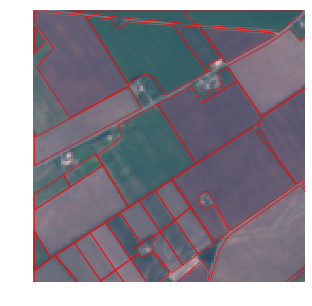

COCO_val2016_000000100006.jpg


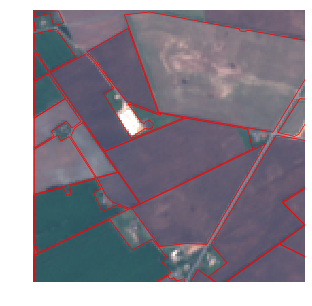

In [9]:
utils.coco.plot_coco(inpath_json=outpath / r'annotations\val2016.json', 
                     inpath_image_folder=outpath / r'images\val2016', 
                     end=2)